In [154]:
!pip install textblob
!pip install gensim

from __future__ import division, print_function
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.merge import Add
from keras.models import Sequential
from sklearn.model_selection import train_test_split

import numpy as np, pandas as pd
import os

from keras.models import model_from_json
from keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('punkt')
import numpy as np
import collections
import os
import pickle
from textblob import TextBlob
import re
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import matplotlib.pyplot as plt

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
DATA_DIR = "InferSent/encoder/data"
EMBED_SIZE = 4096
QA_TRAIN_FILE = "train.tsv"
QA_EMBED_SIZE = 64
BATCH_SIZE = 32
NBR_EPOCHS = 20
vocab_size = 5467

#####Pre-processing the data

In [83]:
train = pd.read_csv("InferSent/encoder/data/train.tsv",sep='\t')
train.head(3)

,ID,Question Stem,Choices,Complete Question,Answer Key
0,7-980,The sun is responsible for,(A) puppies learning new tricks (B) children g...,The sun is responsible for (A) puppies learnin...,D
1,7-584,When standing miles away from Mount Rushmore,(A) the mountains seem very close (B) the moun...,When standing miles away from Mount Rushmore (...,D
2,7-870,When food is reduced in the stomach,(A) the mind needs time to digest (B) take a s...,When food is reduced in the stomach (A) the mi...,C


In [84]:
#Create new features from the answer choices  
for index, row in train.iterrows():
    ans = re.split("(\([A-Z]\))", row['Choices'])
    ans.remove('')
    train.set_value(index,'OptionA',ans[1])
    train.set_value(index,'OptionB',ans[3])
    train.set_value(index,'OptionC',ans[5])
    train.set_value(index,'OptionD',ans[7])
    
#Find the answer key and replace it with the value   
for index, row in train.iterrows():
    ans = re.split("(\([A-Z]\))", row['Choices'])
    ans.remove('')
    if row['Answer Key'] == 'A':
        train.set_value(index,'Result',ans[1])
    elif row['Answer Key'] == 'B':
        train.set_value(index,'Result',ans[3])
    elif row['Answer Key'] == 'C':
        train.set_value(index,'Result',ans[5])
    elif row['Answer Key'] == 'D':
        train.set_value(index,'Result',ans[7])     

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:21: FutureWar

In [85]:
train = train.drop(['ID', 'Choices', 'Complete Question','Answer Key'], axis=1)

In [86]:
train.head(3)

,Question Stem,OptionA,OptionB,OptionC,OptionD,Result
0,The sun is responsible for,puppies learning new tricks,children growing up and getting old,flowers wilting in a vase,"plants sprouting, blooming and wilting","plants sprouting, blooming and wilting"
1,When standing miles away from Mount Rushmore,the mountains seem very close,the mountains are boring,the mountains look the same as from up close,the mountains seem smaller than in photographs,the mountains seem smaller than in photographs
2,When food is reduced in the stomach,the mind needs time to digest,take a second to digest what I said,nutrients are being deconstructed,reader's digest is a body of works,nutrients are being deconstructed


In [91]:
#Split question, candidate answers and right answer to test and train data 
X_Question = train[train.columns[0:1]]
X_Answers = train[train.columns[1:5]]
Y = train.iloc[:,-1]
X_Question_train, X_Question_train,X_Answers_train,X_Answers_test,Y_train, Y_test = train_test_split(X_Question,X_Answers,Y, test_size=0.30)
print(X_Question_train.shape ,X_Question_train.shape, X_Answers_train.shape, X_Answers_test.shape,Y_train.shape,Y_test.shape)

(1488, 1) (1488, 1) (3469, 4) (1488, 4) (3469,) (1488,)


In [100]:
question_maxlen = max([len(X_Question) for q in X_Question])
answer_maxlen = max([len(X_Answers) for a in X_Answers])
seq_maxlen = max([question_maxlen, answer_maxlen])
print(seq_maxlen)

4957


In [ ]:
embeddings_index = dict()
f = open('InferSent/dataset/GloVe/glove.840B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

In [128]:
## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[] 
for line in train['Question Stem'].values: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords


[['sun', 'responsible'], ['standing', 'miles', 'away', 'mount', 'rushmore'], ['food', 'reduced', 'stomach'], ['stars'], ['make', 'telescope']]


In [151]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.initializers import Constant

In [157]:
train = pd.read_csv("InferSent/encoder/data/train.tsv",sep='\t')

MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 15
t = Tokenizer(num_words=MAX_NUM_WORDS)
t.fit_on_texts(train['Question Stem'])
word_index = t.word_index
print('Found %s unique tokens.' % len(word_index)) 

# integer encode the questions
encoded_docs = t.texts_to_sequences(train['Question Stem'])
# pad documents to a max length of 100 words
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print(vocab_size)

## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))


for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    


Found 5466 unique tokens.
5466


In [159]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer_questions = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

(5467, 300)


Text(0.5,1,'example vectors')

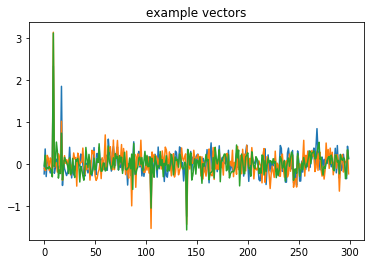

In [160]:
print(embedding_matrix.shape)
plt.plot(embedding_matrix[16])
plt.plot(embedding_matrix[37])
plt.plot(embedding_matrix[18])
plt.title('example vectors')

In [303]:
## extract data
question_maxlen = max([len(question)])
answer_maxlen = max([len(answers)])
seq_maxlen = max([question_maxlen, answer_maxlen])


In [304]:
with open("InferSent/encoder/data/dict_embeddings.pickle", "rb") as f:
    d_context_embeddings = pickle.load(f)
with open("InferSent/encoder/data/dict_embeddings_questions.pickle", "rb") as f:
    d_question_embeddings = pickle.load(f)    
        
dict_context_emb = dict(d_context_embeddings)
dict_question_emb = dict(d_question_embeddings)  

len(dict_context_emb), len(dict_question_emb)
type(d_context_embeddings)

dict

In [305]:
del d_context_embeddings, d_question_embeddings

In [306]:
file=open('InferSent/encoder/data/openbook.txt')
t=file.read()
blob = TextBlob(t)
context=[]

for sentence in blob.sentences:
    word = str(sentence)
    context.append(word)

In [307]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(question)
sequences = tokenizer.texts_to_sequences(question)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=32)
#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)




Found 5466 unique tokens.
Shape of data tensor: (4957, 32)


In [340]:
sent_tokenizer = Tokenizer(num_words=2000)
sent_tokenizer.fit_on_texts(context)
sent_sequences = sent_tokenizer.texts_to_sequences(context)
context_index = sent_tokenizer.word_index
print('Found %s unique tokens.' % len(context_index))

data_sent = pad_sequences(sent_sequences, maxlen=32)
print('Shape of data tensor:', data_sent.shape)

Found 1820 unique tokens.
Shape of data tensor: (1, 32)


In [309]:
print(len(dict_context_emb))

1326


In [339]:
embedding_matrix = np.zeros((len(word_index) + 1, 4096))
for index, row in train.iterrows():
    word = row[1]
    embedding_vector = dict_question_emb.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[index] = embedding_vector
print(embedding_matrix.shape)
print(embedding_matrix)

(5467, 4096)
[[ 0.05154599  0.03336649 -0.00507977 ... -0.03438394 -0.03814263
  -0.02892259]
 [ 0.0456758   0.02630292 -0.03044511 ... -0.01786458 -0.03814263
  -0.02892259]
 [ 0.12085862  0.0785711   0.05753665 ...  0.01377686 -0.03814263
  -0.02892259]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [329]:
for i in range(len(context)):
    train['sentences'] = context[i]
train.head(3)    

,ID,Question Stem,Choices,Complete Question,Answer Key,sentences
0,7-980,The sun is responsible for,(A) puppies learning new tricks (B) children g...,The sun is responsible for (A) puppies learnin...,D,"""A bee is a pollinating animal""\n""A bird is a ..."
1,7-584,When standing miles away from Mount Rushmore,(A) the mountains seem very close (B) the moun...,When standing miles away from Mount Rushmore (...,D,"""A bee is a pollinating animal""\n""A bird is a ..."
2,7-870,When food is reduced in the stomach,(A) the mind needs time to digest (B) take a s...,When food is reduced in the stomach (A) the mi...,C,"""A bee is a pollinating animal""\n""A bird is a ..."


In [341]:
embedding_sentence_matrix = np.zeros((len(dict_context_emb) + 1, 1820))
for item, value in dict_context_emb.items():
    embedding_vector = value
    if embedding_vector is not None:
        #print keys[values.index(item)]
        # words not found in embedding index will be all-zeros.
        embedding_sentence_matrix = embedding_vector
print(type(embedding_sentence_matrix))
print(embedding_sentence_matrix.shape)   

<class 'numpy.ndarray'>
(1, 4096)


In [344]:
#Question Encoding Layer
print("Building model...")
qenc = Sequential()
qenc.add(Embedding(output_dim=EMBED_SIZE, input_dim=vocab_size,
                   weights=[embedding_matrix], mask_zero=True))
# qenc.add(LSTM(EMBED_SIZE,input_shape=seq_maxlen,return_sequences=False))
# qenc.add(Dropout(0.3))

Building model...


In [347]:
#Context Encoding Layer
cenc = Sequential()
cenc.add(Embedding(output_dim=EMBED_SIZE, input_dim=1,
                   weights=[embedding_sentence_matrix], mask_zero=True))
# cenc.add(LSTM(EMBED_SIZE, input_shape=seq_maxlen, return_sequences=False))
# cenc.add(Dropout(0.3))



In [360]:
#Sum the question and context encoding layer

#added = keras.layers.Add()([qenc, cenc])
#merged = Merge([qenc, cenc], mode='sum')

#model = Sequential()
#model.add(Merge([qenc, cenc], mode="sum"))
# model.add(Dense(2, activation="softmax"))

NameError: name 'Merge' is not defined

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

print("Training...")
checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "qa-lstm-best.hdf5"),
    verbose=1, save_best_only=True)
model.fit([Xqtrain, Xatrain], Ytrain, batch_size=BATCH_SIZE,
          nb_epoch=NBR_EPOCHS, validation_split=0.1,
          callbacks=[checkpoint])

print("Evaluation...")
loss, acc = model.evaluate([Xqtest, Xatest], Ytest, batch_size=BATCH_SIZE)
print("Test loss/accuracy final model = %.4f, %.4f" % (loss, acc))

model.save_weights(os.path.join(MODEL_DIR, "qa-lstm-final.hdf5"))
with open(os.path.join(MODEL_DIR, "qa-lstm.json"), "wb") as fjson:
    fjson.write(model.to_json())

model.load_weights(filepath=os.path.join(MODEL_DIR, "qa-lstm-best.hdf5"))
loss, acc = model.evaluate([Xqtest, Xatest], Ytest, batch_size=BATCH_SIZE)
print("Test loss/accuracy best model = %.4f, %.4f" % (loss, acc))

,ID,Question Stem,Choices,Complete Question,Answer Key
0,7-980,The sun is responsible for,(A) puppies learning new tricks (B) children g...,The sun is responsible for (A) puppies learnin...,D
1,7-584,When standing miles away from Mount Rushmore,(A) the mountains seem very close (B) the moun...,When standing miles away from Mount Rushmore (...,D
2,7-870,When food is reduced in the stomach,(A) the mind needs time to digest (B) take a s...,When food is reduced in the stomach (A) the mi...,C
3,7-321,Stars are,(A) warm lights that float (B) made out of nit...,Stars are (A) warm lights that float (B) made ...,C
4,9-732,You can make a telescope with a,(A) straw (B) Glass (C) Candle (D) mailing tube,You can make a telescope with a (A) straw (B) ...,D
5,9-782,Poison causes harm to which of the following?,(A) a Tree (B) a robot (C) a house (D) a car,Poison causes harm to which of the following? ...,A
6,9-87,an inherited characteristic found on all mamma...,(A) nails (B) teeth (C) shoes (D) fur,an inherited characteristic found on all mamma...,D
7,155,What doesn't eliminate waste?,(A) plants (B) mushrooms (C) bacteria (D) robots,What doesn't eliminate waste? (A) plants (B) m...,D
8,1046,As a car approaches you in the night,(A) the headlights become more intense (B) the...,As a car approaches you in the night (A) the h...,A
9,7-637,When the weather changes as it does from Chris...,(A) the air may chill (B) the ground may freez...,When the weather changes as it does from Chris...,D
